# Vectors embeddings with Azure Computer Vision 4

In [1]:
import json
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
import sys

from datetime import datetime
from itertools import islice
from dotenv import load_dotenv
from IPython.display import Image
from PIL import Image as PILImage

In [2]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [3]:
def file_info(file_path):
    """
    File informations
    """
    filename = os.path.basename(file_path)
    size = os.path.getsize(file_path)
    last_modified = datetime.fromtimestamp(os.path.getmtime(file_path)).strftime(
        "%Y-%m-%d %H:%M:%S"
    )

    print(f"Filename: {filename}")
    print(f"Size: {size} bytes")
    print(f"Last modified: {last_modified}")

## 1. Azure Computer Vision 4.0 Florence connection

In [4]:
file_info("azure.env")

Filename: azure.env
Size: 654 bytes
Last modified: 2023-06-21 15:40:50


In [5]:
load_dotenv("azure.env")

acv_key = os.getenv("acv_key")
acv_endpoint = os.getenv("acv_endpoint")

# The azure endpoint should not finished a /
if acv_endpoint.endswith("/"):
    acv_endpoint= acv_endpoint[:-1]

## 2. Functions

In [6]:
def image_url_embedding(imageurl):
    """
    Url image vector embeddings using Azure Computer Vision 4
    """
    version = "?api-version=2023-02-01-preview&modelVersion=latest"
    vec_img_url = acv_endpoint + "/computervision/retrieval:vectorizeImage" + version
    headers = {"Content-type": "application/json", "Ocp-Apim-Subscription-Key": acv_key}

    image = {"url": imageurl}
    r = requests.post(vec_img_url, data=json.dumps(image), headers=headers)
    image_emb = r.json()["vector"]

    return image_emb

In [7]:
def text_embedding(promptxt):
    """
    Text vector embedding text using using Azure Computer Vision 4
    """
    version = "?api-version=2023-02-01-preview&modelVersion=latest"
    vec_txt_url = acv_endpoint + "/computervision/retrieval:vectorizeText" + version
    headers = {"Content-type": "application/json", "Ocp-Apim-Subscription-Key": acv_key}

    prompt = {"text": promptxt}
    r = requests.post(vec_txt_url, data=json.dumps(prompt), headers=headers)
    text_emb = r.json()["vector"]

    return text_emb

In [8]:
def get_cosine_similarity(vector1, vector2):
    """
    Get cosine similarity value between two embedded vectors
    """
    dot_product = sum(x * y for x, y in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum(x * x for x in vector1))
    magnitude2 = math.sqrt(sum(x * x for x in vector2))
    cosine_similarity = dot_product / (magnitude1 * magnitude2)

    return round(cosine_similarity, 7)

In [9]:
def similarity_results(image_emb, prompts):
    """ "
    Get similarity results
    """
    simil_values_list = [
        get_cosine_similarity(image_emb, text_embedding(prompt)) for prompt in prompts
    ]
    sorted_results = sorted(
        zip(prompts, simil_values_list), key=lambda x: x[1], reverse=True
    )

    df = pd.DataFrame(columns=["prompt", "cosine_similarity"])

    for idx, (prompt, simil_val) in enumerate(sorted_results):
        df.loc[idx, "prompt"] = prompt
        df.loc[idx, "cosine_similarity"] = simil_val

    df["cosine_similarity"] = df.cosine_similarity.astype(float)

    return df

## 3. Image and prompts

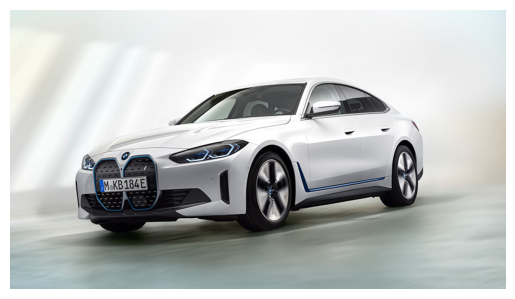

In [10]:
image_url = "https://github.com/retkowsky/images/blob/master/i4.jpg?raw=true"

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

In [11]:
embeddings = image_url_embedding(image_url)
print("Size of the vector embeddings =", len(embeddings))

Size of the vector embeddings = 1024


In [12]:
text = text_embedding("a bird")

In [13]:
print("Size of the vector embeddings =", len(text))

Size of the vector embeddings = 1024


In [14]:
get_cosine_similarity(embeddings, text)

0.1408368

In [15]:
text2 = text_embedding("a BMW white car")

In [16]:
get_cosine_similarity(embeddings, text2)

0.3486093

## 4. Multiple prompts

In [17]:
prompts = [
    "I do not know",
    "a truck",
    "a car",
    "a white car",
    "a BMW white car",
    "a tesla car",
    "a mercedes car",
    "a man",
    "a ford car",
    "an i4 BMW car",
]

In [18]:
df = similarity_results(embeddings, prompts)
cm = sns.light_palette("pink", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,cosine_similarity
0,an i4 BMW car,0.357134
1,a BMW white car,0.348609
2,a white car,0.311181
3,a car,0.268166
4,a tesla car,0.226974
5,a ford car,0.225841
6,a mercedes car,0.221624
7,a truck,0.159409
8,a man,0.151200
9,I do not know,0.148022


In [19]:
df.values.tolist()[0]

['an i4 BMW car', 0.3571342]

### Example 2

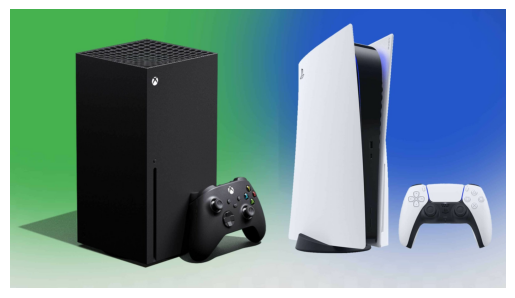

In [20]:
image_url = "https://github.com/retkowsky/images/blob/master/xboxps5.jpg?raw=true"
embeddings = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

In [21]:
prompts = [
    "PS5",
    "Xbox",
    "play station",
    "Sony",
    "controller",
    "Microsoft",
    "games console",
    "guitar",
    "fish",
    "apple",
    "car",
    "street",
    "truck",
    "Miami",
    "black controller",
    "white controller",
]

In [22]:
df = similarity_results(embeddings, prompts)
cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,cosine_similarity
0,Xbox,0.312519
1,games console,0.310376
2,PS5,0.296838
3,white controller,0.275321
4,Microsoft,0.272773
5,controller,0.268224
6,play station,0.263936
7,black controller,0.242193
8,Sony,0.242168
9,truck,0.133850


### Example 3

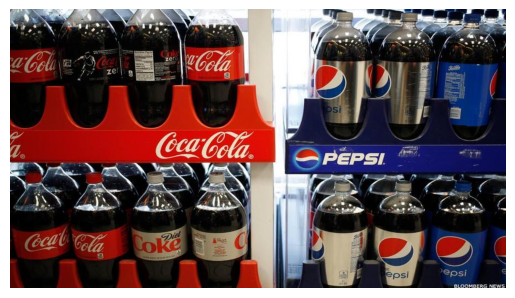

In [23]:
image_url = "https://github.com/retkowsky/images/blob/master/sodas.jpg?raw=true"
embeddings = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

In [24]:
prompts = [
    "a can",
    "coca cola",
    "pepsi",
    "7 up",
    "water",
    "wine",
    "beer",
    "gin",
    "alcohol",
    "lemon",
    "drink",
    "I do not know",
    "food",
    "soda bottles",
    "coke bottle",
]

In [25]:
df = similarity_results(embeddings, prompts)
cm = sns.light_palette("purple", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,cosine_similarity
0,soda bottles,0.319896
1,pepsi,0.315011
2,coke bottle,0.288209
3,coca cola,0.285245
4,drink,0.217713
5,alcohol,0.212916
6,7 up,0.203181
7,food,0.171591
8,beer,0.170266
9,a can,0.165762


## 4. Images similarity with vectors embeddings

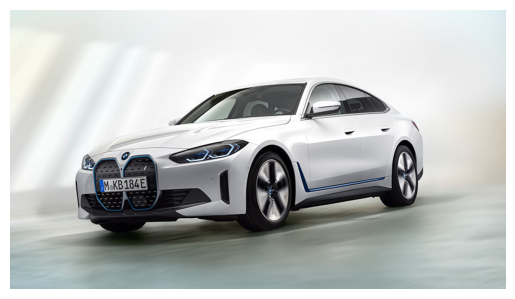

In [26]:
image_url = "https://github.com/retkowsky/images/blob/master/i4.jpg?raw=true"
car = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

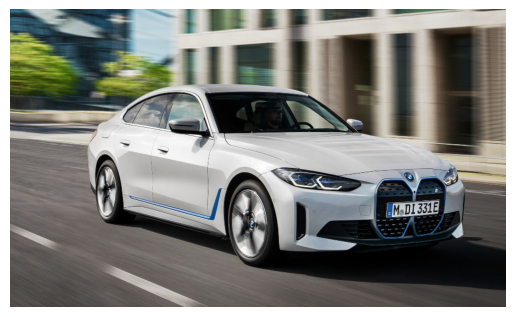

In [27]:
image_url = "https://github.com/retkowsky/images/blob/master/i4_2.jpg?raw=true"
bmwcar = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

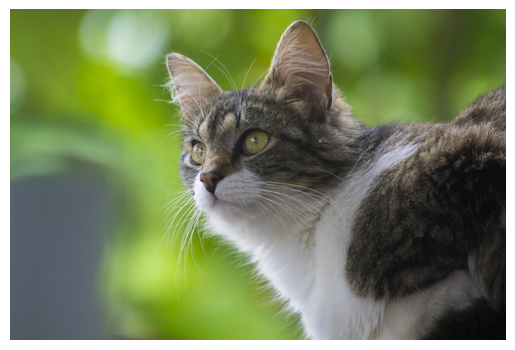

In [28]:
image_url = "https://github.com/retkowsky/images/blob/master/cat.jpg?raw=true"
cat = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

In [29]:
def image_comparison(cosine):
    """
    Decision
    """
    if round(cosine, 2) == 1:
        print("\033[1;31;34m")
        print("Result: Same image")

    elif cosine >= 0.7:
        print("\033[1;31;32m")
        print("Result: Almost similar image")

    else:
        print("\033[1;31;91m")
        print("Result: Different image")

    print("Cosine similarity =", cosine)

In [30]:
print("Cosine similarity between an image and the same image:")
cosine = get_cosine_similarity(car, car)
image_comparison(cosine)

Cosine similarity between an image and the same image:

Result: Same image
Cosine similarity = 1.0


In [31]:
print("Cosine similarity between the car image and the another car image:")
cosine = get_cosine_similarity(car, bmwcar)
image_comparison(cosine)

Cosine similarity between the car image and the another car image:

Result: Almost similar image
Cosine similarity = 0.9472661


In [32]:
print("Cosine similarity between the car image and the cat image:")
cosine = get_cosine_similarity(car, cat)
image_comparison(cosine)

Cosine similarity between the car image and the cat image:

Result: Different image
Cosine similarity = 0.3390264


## 5. Using a local image file

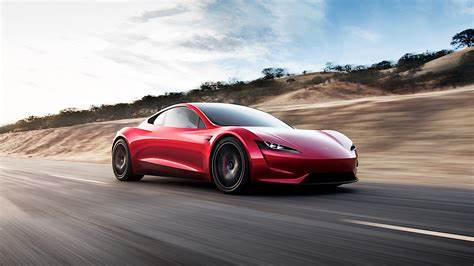

In [33]:
local_image = "car.jpg"
Image(filename=local_image)

In [34]:
def image_embeddings(local_image):
    """
    Local image embeddigns with Azure Computer Vision
    """
    headers = {
        "Content-type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": acv_key,
    }
    version = "?api-version=2023-02-01-preview&modelVersion=latest"
    vec_img_url = acv_endpoint + "/computervision/retrieval:vectorizeImage" + version

    with open(local_image, "rb") as f:
        data = f.read()

    r = requests.post(vec_img_url, data=data, headers=headers)
    image_emb = r.json()["vector"]

    return image_emb

In [35]:
prompts = [
    "a bird",
    "a car",
    "a red car",
    "a red Tesla car",
    "a blue Tesla car",
    "a green Tesla car",
    "a black Tesla car",
    "a white Tesla car",
    "a purple Tesla car",
    "an orange Tesla car",
    "a gray Tesla car",
    "a Mercedes car",
    "a BMW car",
    "a Tesla car",
    "a man",
    "a cat",
    "a dog",
]

In [36]:
image_emb = image_embeddings(local_image)

In [37]:
df = similarity_results(image_emb, prompts)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,cosine_similarity
0,a red Tesla car,0.356283
1,a Tesla car,0.323728
2,an orange Tesla car,0.302530
3,a purple Tesla car,0.299574
4,a green Tesla car,0.290122
5,a red car,0.281566
6,a white Tesla car,0.280062
7,a gray Tesla car,0.275193
8,a blue Tesla car,0.272511
9,a black Tesla car,0.270703


In [38]:
print("This image is", df.values.tolist()[0][0])

This image is a red Tesla car


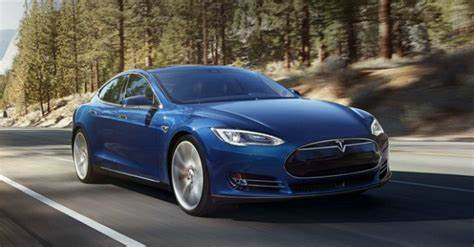

In [39]:
local_image = "car2.jpg"
Image(filename=local_image)

In [40]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, prompts)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,cosine_similarity
0,a blue Tesla car,0.365366
1,a Tesla car,0.332391
2,a green Tesla car,0.323875
3,a gray Tesla car,0.316430
4,a red Tesla car,0.313533
5,a black Tesla car,0.312746
6,a purple Tesla car,0.309051
7,a white Tesla car,0.297423
8,an orange Tesla car,0.289892
9,a car,0.229234


In [41]:
print("This image is", df.values.tolist()[0][0])

This image is a blue Tesla car


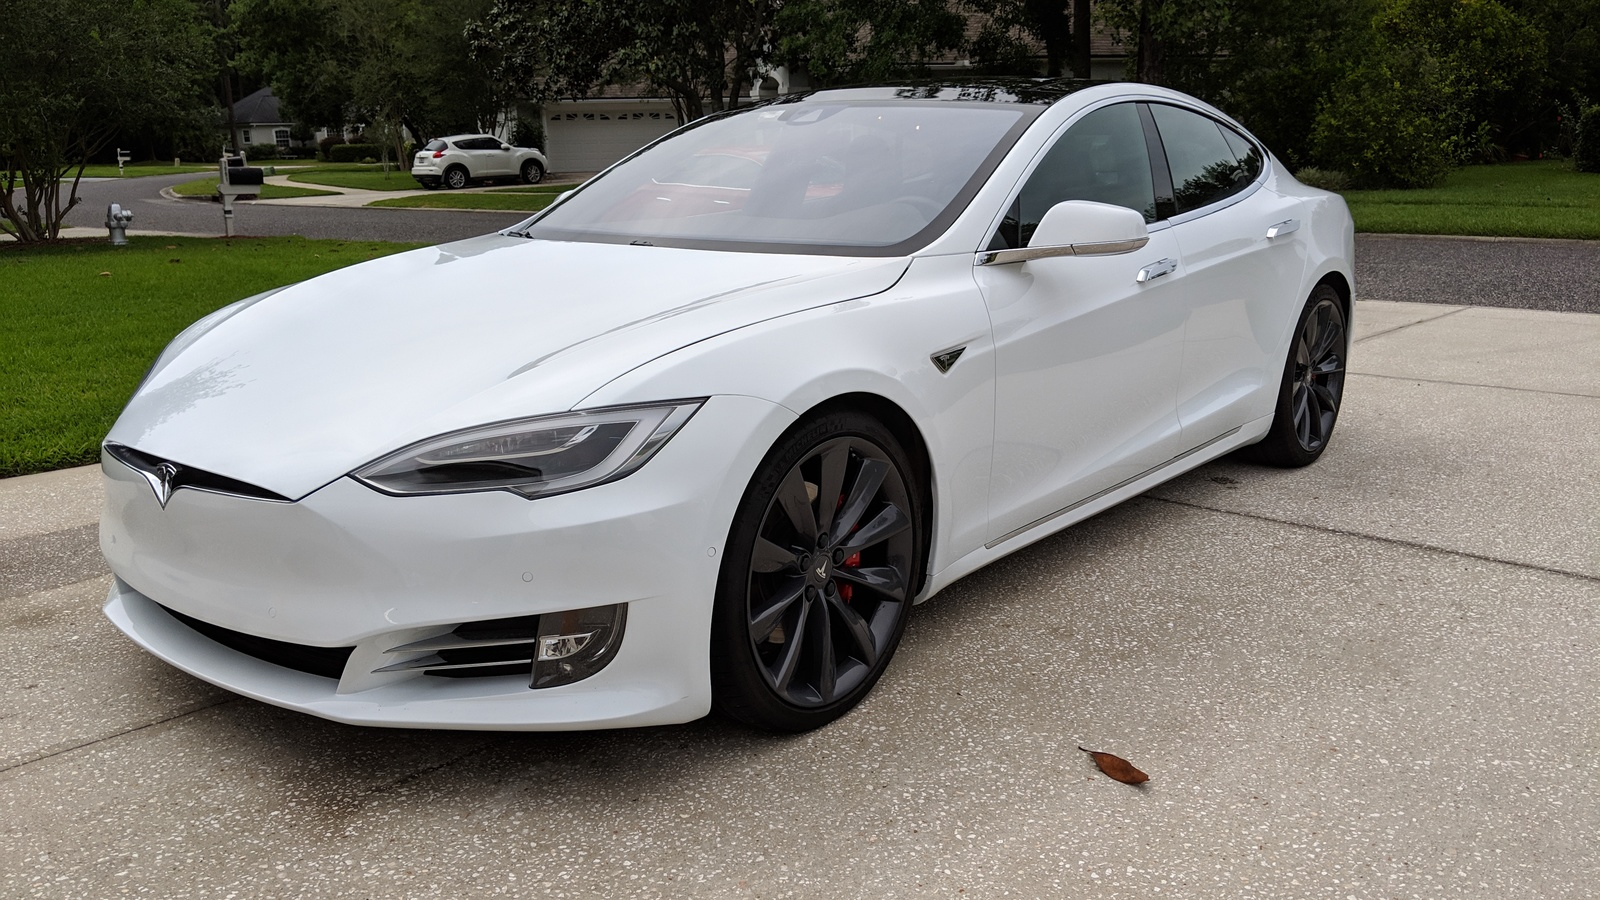

In [42]:
local_image = "car3.jpg"
Image(filename=local_image)

In [43]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, prompts)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,cosine_similarity
0,a white Tesla car,0.382813
1,a Tesla car,0.343686
2,a gray Tesla car,0.342067
3,a black Tesla car,0.317902
4,a green Tesla car,0.306727
5,an orange Tesla car,0.300028
6,a red Tesla car,0.299812
7,a blue Tesla car,0.299007
8,a purple Tesla car,0.284418
9,a car,0.271865


In [44]:
print("This image is", df.values.tolist()[0][0])

This image is a white Tesla car
